# Profit & Loss Analysis

We can now look at how profitable our test and evaluation datasets would have been across different staking strategies.

### Import Libraries


In [71]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import repeatable_functions as rf

### Load Model

In [72]:
# Load model
with open('xg_model_new.pkl', 'rb') as file:
    xg = pickle.load(file)

### Import Datasets

In [73]:
X_train = pd.read_csv('train_test_datasets/X_train_red.csv')
X_test = pd.read_csv('train_test_datasets/X_test_red.csv')
odds_win_df_new = pd.read_csv('train_test_datasets\odds_win_df_new.csv')

### Function to calculate profit from betting on bookmaker favourite

As a benchmark, we can see how much profit or loss would have been achieved should we have simply bet on the favourite. Here, we take the favourite as odds lower than 1.90 rather than 2.00 to account for Bet365's profit margin, since they offer 1.90 (i.e. 52.6% chance) on both sides of a market with equal chances of happening. 

This function will therefore show the hypothetical profit or loss, and the total money staked, should we have bet a £1 stake on all players with bookmaker odds of lower than 1.90:

In [74]:
def returns_from_fav(odds_win_df):
    """
    Calculates and prints the total return and ROI from betting £1 on each match where the 
    bookmaker's odds are below 1.90 (i.e. the favourite).

    This function:
    - Filters the matches where the odds suggest a strong favourite (odds < 1.90).
    - Assumes a flat £1 stake on each qualifying match.
    - Calculates profit or loss per match based on the actual outcome.
    - Outputs the total return, total amount staked, and ROI.

    Parameters:
        odds_win_df (pandas.DataFrame): A DataFrame containing at least the columns 'odds' and 'won'.

    Returns:
        None
    """
    # Filter the DataFrame for rows where the odds are less than 1.90
    filtered_df = odds_win_df[odds_win_df['odds'] < 1.90].copy()

    # Set the stake as £1
    filtered_df.loc[:, 'stake'] = 1

    # Calculate the returns for each bet
    returns = filtered_df.apply(
        lambda row: (row['odds'] * row['stake']) - row['stake'] if row['won'] else -row['stake'],
        axis=1
    )

    # Calculate the total return and total staked
    total_return = returns.sum()
    total_staked = filtered_df['stake'].sum()

    # Calculate ROI
    roi = (total_return / total_staked) * 100 if total_staked > 0 else 0

    # Print results
    print(f"Total return from betting on favourite: £{total_return:.2f}")
    print(f"Total staked: £{total_staked:.2f}")
    print(f"ROI: {roi:.2f}%")


In [75]:
returns_from_fav(odds_win_df_new)

Total return from betting on favourite: £-336.89
Total staked: £6320.00
ROI: -5.33%


We can see that without our model, if we had simply bet a £1 flat stake on every player the bookmaker had predicted to win then we would have a negative 5.40% ROI.

### Function to calculate profit/loss from betting on model win predictions

We can now build a function to calculate the hypothetical profit or loss, and the money staked, should we have bet a £1 stake on every match which the model predicted the player to win:

In [76]:
def returns_from_model_pred_win(odds_win_df):
    """
    Calculates the return and ROI from betting £1 on each match where the model predicted a win.

    This function:
    - Filters the dataset to include only rows where the model predicted a win ('pred_win' == 1).
    - Assumes a flat £1 stake on each bet.
    - Computes net profit for each prediction based on actual match outcomes and bookmaker odds.
    - Prints the total net profit, total amount staked, and ROI.
    - Returns all values for further analysis.

    Parameters:
        odds_win_df (pandas.DataFrame): A DataFrame containing at least the columns:
                                        'pred_win', 'won', and 'odds'.

    Returns:
        tuple:
            total_net_profit (float): The overall profit/loss from the strategy.
            total_staked (float): The total amount staked across all bets.
            roi (float): Return on investment as a percentage.
    """
    # Filter the DataFrame for rows where the model predicted a win
    filtered_df = odds_win_df[odds_win_df['pred_win'] == 1].copy()

    # Set the stake as £1
    filtered_df.loc[:, 'stake'] = 1

    # Calculate the net profit (or loss) for each bet
    filtered_df['net_profit'] = filtered_df.apply(
        lambda row: (row['odds'] * row['stake']) - row['stake'] if row['won'] else -row['stake'],
        axis=1
    )

    # Calculate the total net profit and total staked
    total_net_profit = filtered_df['net_profit'].sum()
    total_staked = filtered_df['stake'].sum()

    # Calculate ROI
    roi = (total_net_profit / total_staked) * 100 if total_staked > 0 else 0

    # Print the results
    print(f"Total net profit from betting on player model predicted to win: £{total_net_profit:.2f}")
    print(f"Total staked: £{total_staked:.2f}")
    print(f"ROI: {roi:.2f}%")



In [77]:
returns_from_model_pred_win(odds_win_df_new)

Total net profit from betting on player model predicted to win: £182.90
Total staked: £6588.00
ROI: 2.78%


### Function to calculate profit/loss from betting on model odds lower than bookmakers

We can now build a function to calculate the hypothetical profit or loss, and the money staked, should we have bet a £1 stake on every match which the model had lower odds than the bookmaker, i.e. where the model is predicting the player to win with more certainty than the bookmaker:

In [78]:
def returns_from_lower_odds(odds_win_df):
    """
    Calculates the return and ROI from betting £1 on matches where the model's odds imply a 
    higher chance of winning than the bookmaker's odds.

    This strategy assumes a bet is placed when the model's implied probability 
    (converted to odds) suggests better value than the bookmaker.

    The function:
    - Filters for cases where model odds are lower than bookmaker odds.
    - Applies a flat £1 stake per bet.
    - Computes the return or loss for each bet based on actual outcomes.
    - Prints the total return, amount staked, and ROI.

    Parameters:
        odds_win_df (pandas.DataFrame): DataFrame containing at least the following columns:
                                        'model_odds', 'odds', and 'won'.

    Returns:
        tuple:
            total_return (float): The total profit or loss from the strategy.
            total_staked (float): The total money staked.
            roi (float): Return on investment as a percentage.
    """
    # Filter for value bets based on lower model odds
    filtered_df = odds_win_df[odds_win_df['model_odds'] < odds_win_df['odds']].copy()

    # Set a flat stake of £1 per bet
    filtered_df.loc[:, 'stake'] = 1

    # Calculate returns for each bet
    returns = filtered_df.apply(
        lambda row: (row['odds'] * row['stake']) - row['stake'] if row['won'] else -row['stake'],
        axis=1
    )

    # Aggregate total return and total amount staked
    total_return = returns.sum()
    total_staked = filtered_df['stake'].sum()

    # Calculate ROI
    roi = (total_return / total_staked) * 100 if total_staked > 0 else 0

    # Print summary
    print(f"Total returns from betting on players where model odds are lower than bookmakers: £{total_return:.2f}")
    print(f"Total staked: £{total_staked:.2f}")
    print(f"ROI: {roi:.2f}%")



In [79]:
returns_from_lower_odds(odds_win_df_new)

Total returns from betting on players where model odds are lower than bookmakers: £85.58
Total staked: £5180.00
ROI: 1.65%


### Function to calculate profit/loss from betting on model win predictions with odds lower than bookmakers

We can now build a function to calculate the hypothetical profit or loss, and the money staked, should we have bet a £1 stake on every match which the model predicted the player to win and had lower odds than the bookmaker, i.e. where the model is predicting the player to win, and to win with more certainty than the bookmaker:

In [80]:
def returns_lower_odds_and_pred_win(odds_win_df):
    """
    Calculates the return and ROI from betting £1 only on matches where:
    - The model predicted a win (`pred_win` == 1), and
    - The model's odds implied a higher probability (i.e. were lower) than the bookmaker's odds.

    This strategy combines confidence (prediction of a win) with value (model odds offering 
    better value than the bookmaker), simulating a more selective betting approach.

    The function:
    - Filters the test data accordingly.
    - Applies a flat £1 stake per qualifying match.
    - Calculates the return for each bet based on the match outcome.
    - Prints the total return, total amount staked, and ROI.

    Parameters:
        odds_win_df (pandas.DataFrame): DataFrame including 'pred_win', 'model_odds',
                                        'odds', and 'won' columns.

    Returns:
        tuple:
            total_return (float): The total profit/loss from the strategy.
            total_staked (float): Total amount staked.
            roi (float): Return on investment percentage.
    """
    # Filter for predicted wins where model odds < bookmaker odds
    filtered_df = odds_win_df[
        (odds_win_df['pred_win'] == 1) &
        (odds_win_df['model_odds'] < odds_win_df['odds'])
    ].copy()

    # Flat £1 stake per qualifying match
    filtered_df.loc[:, 'stake'] = 1

    # Calculate returns
    returns = filtered_df.apply(
        lambda row: (row['odds'] * row['stake']) - row['stake'] if row['won'] else -row['stake'],
        axis=1
    )

    # Total return and total staked
    total_return = returns.sum()
    total_staked = filtered_df['stake'].sum()

    # Calculate ROI
    roi = (total_return / total_staked) * 100 if total_staked > 0 else 0

    # Print summary
    print(f"Total returns from betting where model predicted a win and odds were lower than bookmakers: £{total_return:.2f}")
    print(f"Total staked: £{total_staked:.2f}")
    print(f"ROI: {roi:.2f}%")



In [81]:
returns_lower_odds_and_pred_win(odds_win_df_new)

Total returns from betting where model predicted a win and odds were lower than bookmakers: £294.17
Total staked: £3291.00
ROI: 8.94%


### Function to calculate profit/loss from betting on model lose predictions with odds lower than bookmakers

We can now build a function to calculate the hypothetical profit or loss, and the money staked, should we have bet a £1 stake on every match which the model predicted the player to lose and had lower odds than the bookmaker, i.e. where the model is predicting the player to lose, but still believes they have more chance of winning than the bookmaker does:

In [82]:
def returns_lower_odds_and_pred_lose(odds_win_df):
    """
    Calculates the return and ROI from betting £1 on matches where:
    - The model predicted the player would lose (`pred_win` == 0), and
    - The model's odds were lower than the bookmaker's odds, implying better value.

    This strategy explores cases where the model disagrees with the bookmaker's implied probability,
    suggesting possible underestimation of the player's chances.

    The function:
    - Filters the dataset accordingly.
    - Applies a flat £1 stake to each selected match.
    - Calculates the return or loss for each bet based on actual outcomes.
    - Prints the total return, total staked, and ROI.

    Parameters:
        odds_win_df (pandas.DataFrame): A DataFrame containing 'pred_win', 'model_odds',
                                        'odds', and 'won' columns.

    Returns:
        tuple:
            total_return (float): Net profit/loss from the bets.
            total_staked (float): Total money staked.
            roi (float): Return on investment as a percentage.
    """
    # Filter for predicted losses where model odds < bookmaker odds
    filtered_df = odds_win_df[
        (odds_win_df['pred_win'] == 0) &
        (odds_win_df['model_odds'] < odds_win_df['odds'])
    ].copy()

    # Flat £1 stake per selected bet
    filtered_df.loc[:, 'stake'] = 1

    # Calculate returns for each bet
    returns = filtered_df.apply(
        lambda row: (row['odds'] * row['stake']) - row['stake'] if row['won'] else -row['stake'],
        axis=1
    )

    # Total return and total amount staked
    total_return = returns.sum()
    total_staked = filtered_df['stake'].sum()

    # Calculate ROI
    roi = (total_return / total_staked) * 100 if total_staked > 0 else 0

    # Print summary
    print(f"Total returns from betting on players where model odds are lower than B365 and model predicted to lose: £{total_return:.2f}")
    print(f"Total staked: £{total_staked:.2f}")
    print(f"ROI: {roi:.2f}%")



In [83]:
returns_lower_odds_and_pred_lose(odds_win_df_new)

Total returns from betting on players where model odds are lower than B365 and model predicted to lose: £-208.59
Total staked: £1889.00
ROI: -11.04%


## Evaluating on 2023-2025 Results

We can now see how profitable the model would have been if we had built it in 2022 and had run it on all games from 2023 to March 2025. Since this data was completely removed from the model building process, and occurred after all the data in the model training and testing sets, we can assume that this will provide an accurate representation on how well the model will perform on future data.

First we can load the previously saved evaluation dataset as well as the training dataset:

In [84]:
# Load datasets
player_match_df_23_25 = pd.read_csv('datasets\player_match_df_23_25.csv')
X_train = pd.read_csv('train_test_datasets\X_train_red.csv')

In [ ]:
player_match_df_23_25['date'] = pd.to_datetime(player_match_df_23_25['date'])


,Series,Surface,Round,date,player_rank,opp_rank,player_pts,opp_pts,odds,rank_diff,...,ss_pts_score_sum_past9,ss_pts_score_mean_past9,ss_pts_score_std_past9,ss_pts_score_min_past9,ss_pts_score_max_past9,ss_pts_score_sum_past10,ss_pts_score_mean_past10,ss_pts_score_std_past10,ss_pts_score_min_past10,ss_pts_score_max_past10
0,main_tour,clay,round1,2023-04-04,71.0,232.0,733.0,242.0,1.22,161.0,...,6836.0,759.555556,3634.728673,-4983.0,5257.0,11787.0,1178.7,3674.255875,-4983.0,5257.0
1,main_tour,hard,round1,2023-02-07,59.0,118.0,820.0,452.0,1.25,59.0,...,11347.0,1260.777778,4740.568736,-4556.0,9910.0,11347.0,1134.7,4487.198335,-4556.0,9910.0


### Function to prepare evaluation dataset for analysis

We will now build a function to filter this evaluation dataset to only include the columns that were used in the model training, and then generate predicitions and probabilities on the evaluation dataset using the final selected model:

In [15]:
def prepare_odds_predictions(df, model, X_train):
    """
    Prepares a test set for prediction and adds model-based predictions and odds to the original DataFrame.

    This function:
    - Extracts the feature columns used during training from the provided X_train.
    - Selects these columns from the input DataFrame, along with 'odds', 'won', and 'year'.
    - Uses the trained model to predict outcomes and model-implied odds.
    - Appends predictions to the original DataFrame using `add_preds_probs`.

    Parameters:
        df (pandas.DataFrame): The full DataFrame to generate predictions on (e.g. test matches).
        model (fitted model): A trained classification model with `predict` and `predict_proba` methods.
        X_train (pandas.DataFrame): The training DataFrame, used to extract the list of feature columns.

    Returns:
        pandas.DataFrame: The original input DataFrame with added 'model_odds' and 'pred_win' columns.
    """
    # Get feature column names from X_train
    feature_columns = X_train.columns.tolist()

    # Subset input DataFrame to include only features and reference columns, then make a copy
    df_subset = df[feature_columns + ['odds', 'won', 'date', 'year']].copy()

    # Create feature matrix for prediction
    X_test = df_subset.drop(columns=['odds', 'won', 'date', 'year'])

    # Add model predictions and model-derived odds
    df_with_preds = rf.add_preds_probs(df_subset, X_test, model)

    return df_with_preds


In [63]:
# Run the function
odds_win_df_23_25 = prepare_odds_predictions(player_match_df_23_25, xg, X_train)

Similarly to our test dataset, we can remove bookmaker odds that are below 1.00 or above 20.0 to remove incorrect or anomalous data that may skew results:

In [64]:
odds_win_df_23_25 = odds_win_df_23_25[(odds_win_df_23_25['odds'] > 1) & (odds_win_df_23_25['odds'] <= 20)]

### Run profit/loss functions on evaluation dataset

We can now run the previously defined profit/loss functions to show how profitable the model would have been on our evaluation dataset for the different scenarios:

In [65]:
returns_from_fav(odds_win_df_23_25)

Total return from betting on favourite: £-290.94
Total staked: £6286.00
ROI: -4.63%


In [66]:
returns_from_model_pred_win(odds_win_df_23_25)

Total net profit from betting on player model predicted to win: £332.20
Total staked: £6523.00
ROI: 5.09%


In [67]:
returns_from_lower_odds(odds_win_df_23_25)

Total returns from betting on players where model odds are lower than bookmakers: £390.94
Total staked: £5119.00
ROI: 7.64%


In [68]:
returns_lower_odds_and_pred_win(odds_win_df_23_25)

Total returns from betting where model predicted a win and odds were lower than bookmakers: £503.32
Total staked: £3388.00
ROI: 14.86%


In [69]:
returns_lower_odds_and_pred_lose(odds_win_df_23_25)

Total returns from betting on players where model odds are lower than B365 and model predicted to lose: £-112.38
Total staked: £1731.00
ROI: -6.49%


## Summary

We can see that our model would have been marginally (2.81%) profitable had we bet on every game where the model predicted the player to win and the model’s odds were lower than the bookmaker's, which is clearly the most sensible betting strategy. While this is encouraging and suggests that the model may be identifying genuine value, it's important to interpret these results with caution.

Sports betting outcomes are inherently noisy and prone to short-term fluctuations. A 2.81% edge, while statistically promising, can easily be wiped out by variance, particularly over smaller sample sizes or streaky outcomes. Additionally, betting markets evolve, the model's performance may degrade over time.

It's also worth noting that a model showing marginal profitability under simulated conditions doesn’t guarantee consistent success in live betting environments. Factors like odds movement (line changes), delays in placing bets, limited market liquidity, and bet restrictions can all affect real-world returns.

## Alternative Staking Methods

We can now look at how our profit or loss would have changed over time using different staking methods:

### Function to show profit over time using a flat-staking method

We can build a function to plot how our cumulative profit or loss would change over time assuming we bet a flat £10 stake on each value bet across the evaluation dataset:

In [23]:

def plot_cumulative_profit(odds_win_df, stake=10):
    """
    Plots cumulative profit/loss over time assuming a flat stake per value bet,
    and prints total and peak performance metrics including dates of max/min profit.

    Value bets are defined as:
    - The model predicted a win (pred_win == 1), and
    - The model's odds are better value than the bookmaker's (model_odds < odds)

    Parameters:
        odds_win_df (pd.DataFrame): Must contain 'date', 'pred_win', 'model_odds', 'odds', 'won'
        stake (float): Flat amount staked per bet

    Returns:
        pd.DataFrame: Filtered DataFrame with profit and cumulative profit columns.
    """
    df = odds_win_df.copy()
    df.columns = df.columns.str.lower()

    required_cols = {'date', 'pred_win', 'model_odds', 'odds', 'won'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")

    df['date'] = pd.to_datetime(df['date'])

    # Filter value bets
    filtered = df[(df['pred_win'] == 1) & (df['model_odds'] < df['odds'])].copy()

    if filtered.empty:
        print("No qualifying value bets found.")
        return filtered

    # Simulate betting
    filtered['profit'] = filtered.apply(
        lambda row: (row['odds'] * stake) - stake if row['won'] else -stake,
        axis=1
    )

    filtered = filtered.sort_values('date')
    filtered['cumulative_profit'] = filtered['profit'].cumsum()
    filtered['roi'] = filtered['cumulative_profit'] / ((filtered.index + 1) * stake) * 100

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(filtered['date'], filtered['cumulative_profit'], linewidth=2, color='green')
    plt.title(f"Cumulative Profit/Loss Over Time (£{stake} Stake per Bet)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit (£)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Stats
    total_profit = filtered['cumulative_profit'].iloc[-1]
    total_staked = len(filtered) * stake
    final_roi = (total_profit / total_staked) * 100

    max_profit = filtered['cumulative_profit'].max()
    min_profit = filtered['cumulative_profit'].min()
    max_profit_date = filtered.loc[filtered['cumulative_profit'].idxmax(), 'date'].date()
    min_profit_date = filtered.loc[filtered['cumulative_profit'].idxmin(), 'date'].date()

    print(f"Performance Summary ({len(filtered)} bets @ £{stake} each):")
    print(f"Final Profit/Loss: £{total_profit:.2f}")
    print(f"Final ROI: {final_roi:.2f}%")
    print(f"Max Profit: £{max_profit:.2f} on {max_profit_date}")
    print(f"Min Profit: £{min_profit:.2f} on {min_profit_date}")


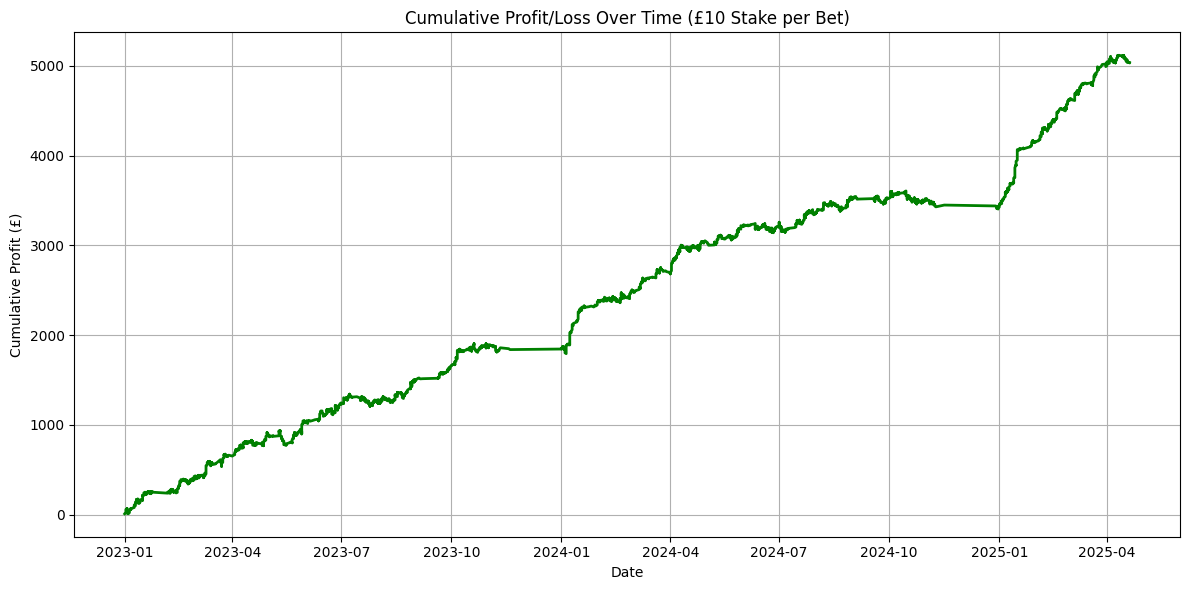

Performance Summary (3388 bets @ £10 each):
Final Profit/Loss: £5033.20
Final ROI: 14.86%
Max Profit: £5117.40 on 2025-04-11
Min Profit: £9.10 on 2023-01-01


In [24]:
plot_cumulative_profit(odds_win_df_23_25)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_kelly_constant_base(odds_win_df, kelly_bankroll=50, kelly_fraction=1.0):
    """
    Simulates betting using a fixed £50 virtual bankroll for Kelly stake sizing on each bet,
    regardless of profit/loss. Stakes are based on that fixed bankroll and accumulate over time.

    Parameters:
        odds_win_df (pd.DataFrame): Must include 'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'
        kelly_bankroll (float): The fixed base used to size Kelly stakes per bet (default £50)
        kelly_fraction (float): Fraction of the full Kelly stake to use (e.g. 0.25 = quarter-Kelly)

    Returns:
        pd.DataFrame: Filtered DataFrame with stake, profit, and cumulative profit over time.
    """
    df = odds_win_df.copy()
    df.columns = df.columns.str.lower()

    required_cols = {'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")

    df['date'] = pd.to_datetime(df['date'])

    # Filter for value bets where model predicts a win and sees value
    filtered = df[(df['pred_win'] == 1) & (df['model_odds'] < df['odds'])].copy()

    if filtered.empty:
        print("No qualifying value bets found.")
        return filtered

    # Sort chronologically
    filtered = filtered.sort_values('date').reset_index(drop=True)

    # Track results
    stakes = []
    profits = []
    cumulative_profits = []

    cum_profit = 0

    for _, row in filtered.iterrows():
        b = row['odds'] - 1
        p = row['model_prob']
        q = 1 - p

        # Kelly fraction of fixed virtual bankroll
        kelly_raw = (b * p - q) / b
        kelly_stake = max(kelly_raw, 0) * kelly_fraction * kelly_bankroll

        # Calculate profit
        profit = kelly_stake * (row['odds'] - 1) if row['won'] else -kelly_stake
        cum_profit += profit

        stakes.append(kelly_stake)
        profits.append(profit)
        cumulative_profits.append(cum_profit)

    filtered['stake'] = stakes
    filtered['profit'] = profits
    filtered['cumulative_profit'] = cumulative_profits

    # Plot cumulative profit
    plt.figure(figsize=(12, 6))
    plt.plot(filtered['date'], filtered['cumulative_profit'], linewidth=2, color='purple')
    plt.title(
        f"Cumulative Profit Using Constant £{kelly_bankroll} Kelly Base "
        f"({kelly_fraction:.2f} Kelly Fraction)"
    )
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit (£)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary
    total_profit = filtered['cumulative_profit'].iloc[-1]
    total_staked = sum(stakes)
    final_roi = (total_profit / total_staked) * 100 if total_staked > 0 else 0

    max_profit = max(cumulative_profits)
    min_profit = min(cumulative_profits)
    max_date = filtered.loc[filtered['cumulative_profit'].idxmax(), 'date'].date()
    min_date = filtered.loc[filtered['cumulative_profit'].idxmin(), 'date'].date()

    print(f"Kelly Betting Summary ({len(filtered)} bets):")
    print(f"Total Profit: £{total_profit:.2f}")
    print(f"Total Staked: £{total_staked:.2f}")
    print(f"Final ROI:    {final_roi:.2f}%")
    print(f"Max Profit:   £{max_profit:.2f} on {max_date}")
    print(f"Min Profit:   £{min_profit:.2f} on {min_date}")


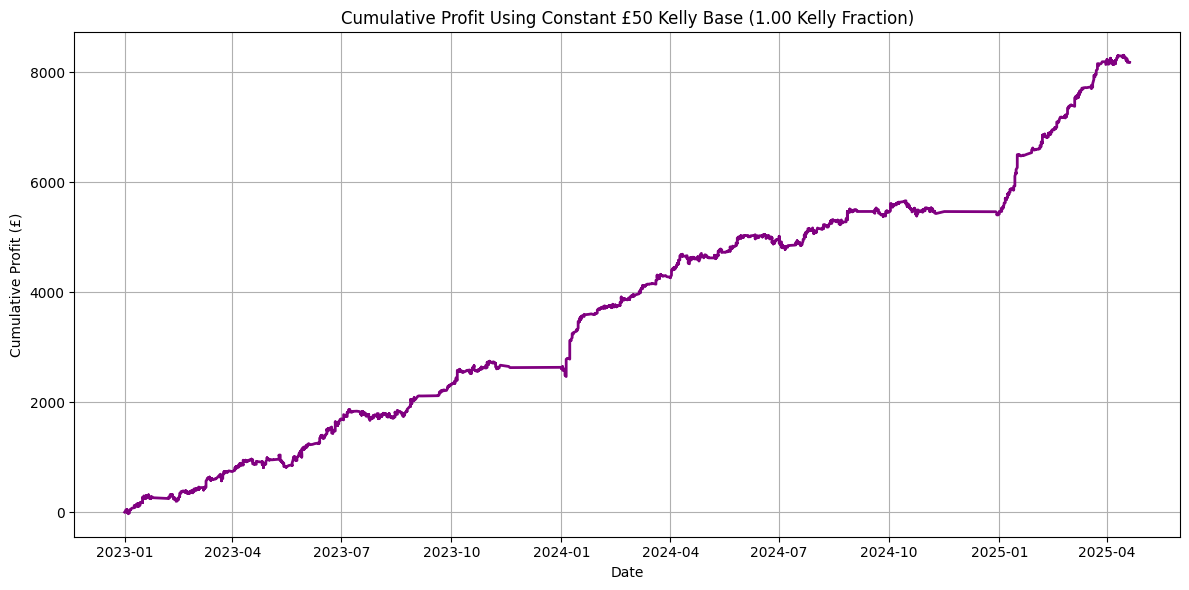

Kelly Betting Summary (3388 bets):
Total Profit: £8172.24
Total Staked: £41500.18
Final ROI:    19.69%
Max Profit:   £8305.21 on 2025-04-15
Min Profit:   £-25.05 on 2023-01-04


In [26]:
plot_kelly_constant_base(odds_win_df_23_25, kelly_fraction=1.0)

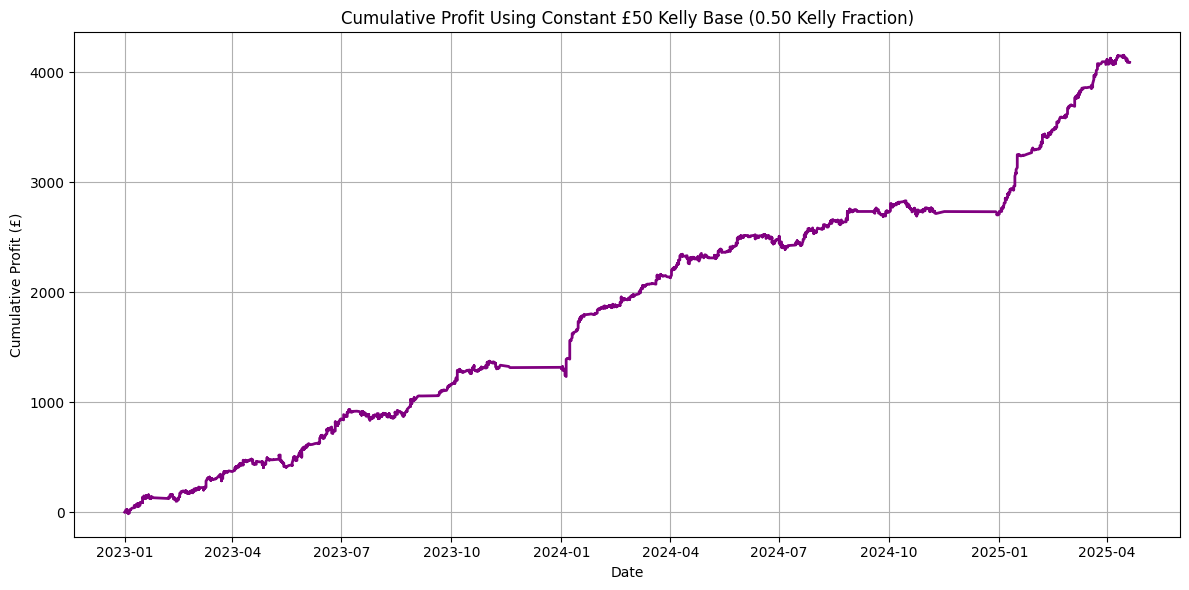

Kelly Betting Summary (3388 bets):
Total Profit: £4086.12
Total Staked: £20750.09
Final ROI:    19.69%
Max Profit:   £4152.60 on 2025-04-15
Min Profit:   £-12.52 on 2023-01-04


In [27]:
plot_kelly_constant_base(odds_win_df_23_25, kelly_fraction=0.5)

In [28]:
def plot_kelly_dynamic_proportional_bankroll(
    odds_win_df,
    initial_bankroll=50,
    bankroll_fraction=1.0,
    kelly_fraction=1.0,
    min_bankroll=50
):
    """
    Simulates Kelly staking using a cumulative bankroll, with bet sizing based on a proportion
    of the bankroll (or minimum £50), and calculates profit/loss over time.

    Parameters:
        odds_win_df (pd.DataFrame): Must include 'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'
        initial_bankroll (float): Starting bankroll value
        bankroll_fraction (float): Proportion of the bankroll used to size each bet (0.5 = half bankroll)
        kelly_fraction (float): Fraction of the full Kelly stake to use (e.g. 0.25 for quarter-Kelly)
        min_bankroll (float): Minimum bankroll base to use for bet sizing (e.g. £50)

    Returns:
        pd.DataFrame: Filtered bets with stake, profit, and updated bankroll history.
    """
    df = odds_win_df.copy()
    df.columns = df.columns.str.lower()

    required_cols = {'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")

    df['date'] = pd.to_datetime(df['date'])

    # Filter value bets where model predicts a win and sees value
    filtered = df[(df['pred_win'] == 1) & (df['model_odds'] < df['odds'])].copy()
    if filtered.empty:
        print("No qualifying value bets found.")
        return filtered

    filtered = filtered.sort_values('date').reset_index(drop=True)

    bankroll = initial_bankroll
    stakes = []
    profits = []
    bankrolls = []

    for _, row in filtered.iterrows():
        b = row['odds'] - 1
        p = row['model_prob']
        q = 1 - p

        # Use a fraction of the bankroll, or min_bankroll if bankroll too low
        base = max(bankroll * bankroll_fraction, min_bankroll)

        kelly_raw = (b * p - q) / b
        stake = max(kelly_raw, 0) * kelly_fraction * base

        profit = stake * (row['odds'] - 1) if row['won'] else -stake
        bankroll += profit

        stakes.append(stake)
        profits.append(profit)
        bankrolls.append(bankroll)

    filtered['stake'] = stakes
    filtered['profit'] = profits
    filtered['bankroll'] = bankrolls

    # Plot bankroll over time
    plt.figure(figsize=(12, 6))
    plt.plot(filtered['date'], filtered['bankroll'], linewidth=2, color='darkcyan')
    plt.title(
        f"Cumulative Bankroll Using Kelly (Initial: £{initial_bankroll}, "
        f"Bankroll %: {bankroll_fraction:.2f}, Kelly %: {kelly_fraction:.2f}, Min Base: £{min_bankroll})"
    )
    plt.xlabel("Date")
    plt.ylabel("Bankroll (£)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    final_bankroll = bankrolls[-1]
    total_profit = final_bankroll - initial_bankroll
    total_staked = sum(stakes)
    roi = (total_profit / total_staked) * 100 if total_staked > 0 else 0

    max_bankroll = max(bankrolls)
    min_bankroll_val = min(bankrolls)
    max_date = filtered.loc[filtered['bankroll'].idxmax(), 'date'].date()
    min_date = filtered.loc[filtered['bankroll'].idxmin(), 'date'].date()

    print(f"Proportional Kelly Summary ({len(filtered)} bets):")
    print(f"Initial Bankroll: £{initial_bankroll:.2f}")
    print(f"Final Bankroll:   £{final_bankroll:.2f}")
    print(f"Total Profit:     £{total_profit:.2f}")
    print(f"Total Staked:     £{total_staked:.2f}")
    print(f"Final ROI:        {roi:.2f}%")
    print(f"Peak Bankroll:    £{max_bankroll:.2f} on {max_date}")
    print(f"Min Bankroll:     £{min_bankroll_val:.2f} on {min_date}")


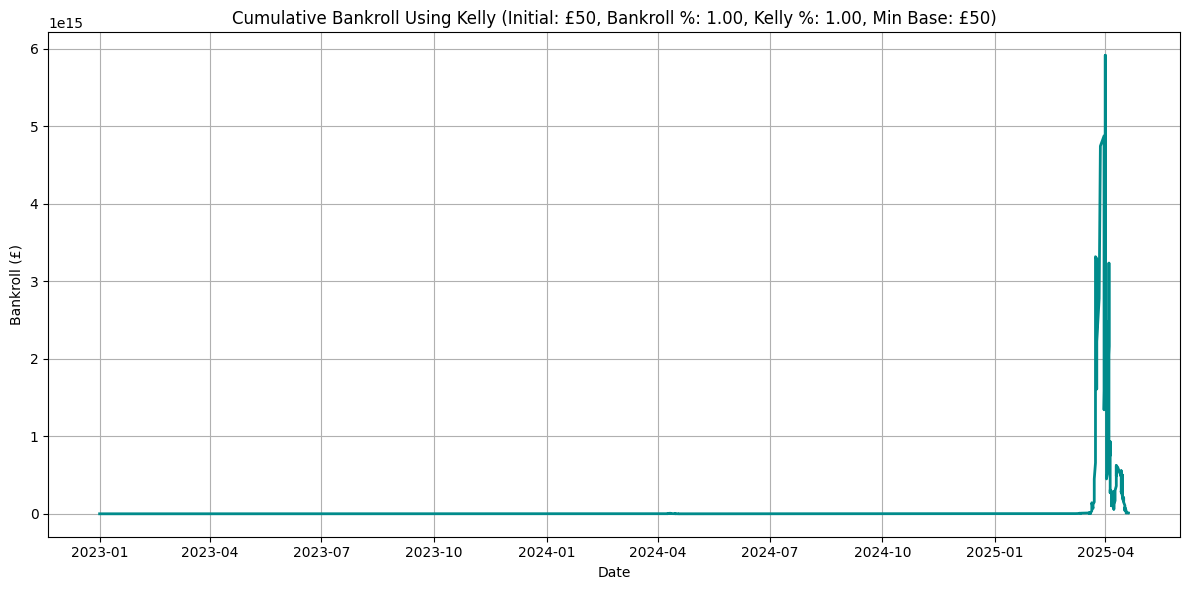

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £8277587526253.67
Total Profit:     £8277587526203.67
Total Staked:     £38831640682448088.00
Final ROI:        0.02%
Peak Bankroll:    £5915719149689404.00 on 2025-04-01
Min Bankroll:     £-65.08 on 2024-12-31


In [29]:
plot_kelly_dynamic_proportional_bankroll(odds_win_df_23_25)

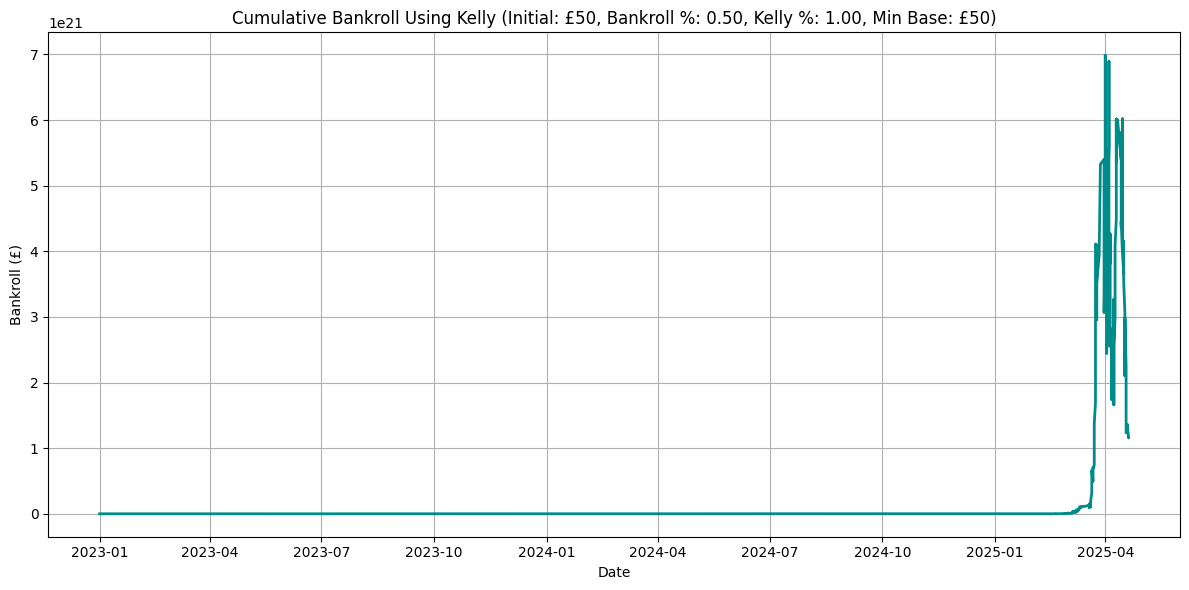

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £1163847802862453915648.00
Total Profit:     £1163847802862453915648.00
Total Staked:     £71416654158848090701824.00
Final ROI:        1.63%
Peak Bankroll:    £6988175794553000820736.00 on 2025-04-01
Min Bankroll:     £24.50 on 2023-01-04


In [30]:
plot_kelly_dynamic_proportional_bankroll(odds_win_df_23_25, bankroll_fraction=0.5, kelly_fraction=1.0)

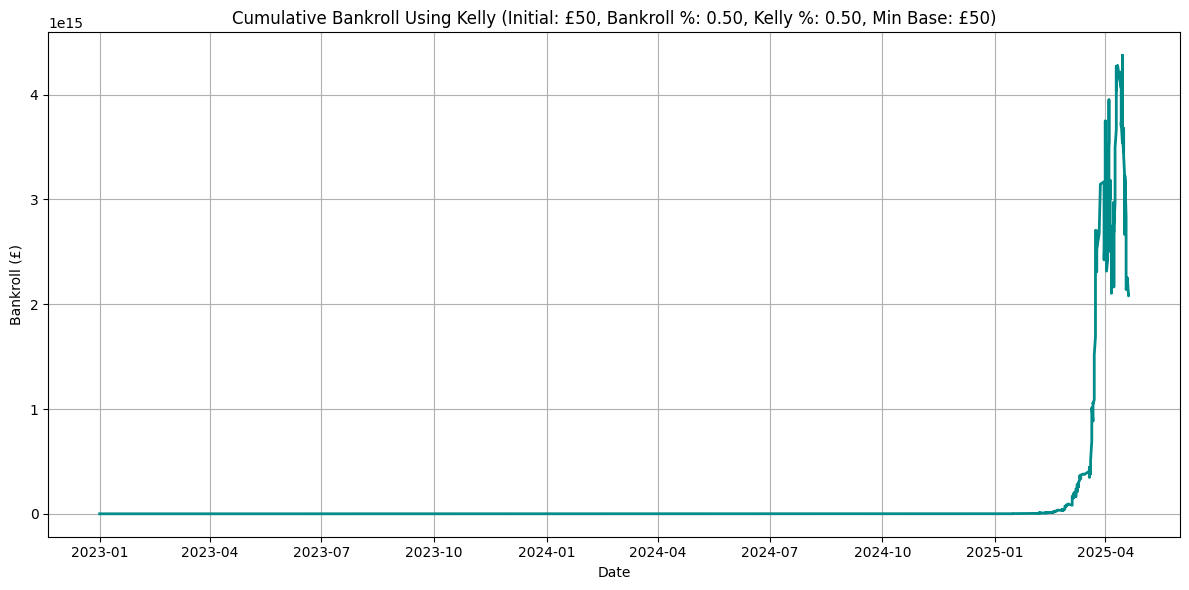

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £2087515578647406.75
Total Profit:     £2087515578647356.75
Total Staked:     £31396586989531400.00
Final ROI:        6.65%
Peak Bankroll:    £4376477436862988.50 on 2025-04-15
Min Bankroll:     £37.48 on 2023-01-04


In [31]:
plot_kelly_dynamic_proportional_bankroll(odds_win_df_23_25, bankroll_fraction=0.5, kelly_fraction=0.5)

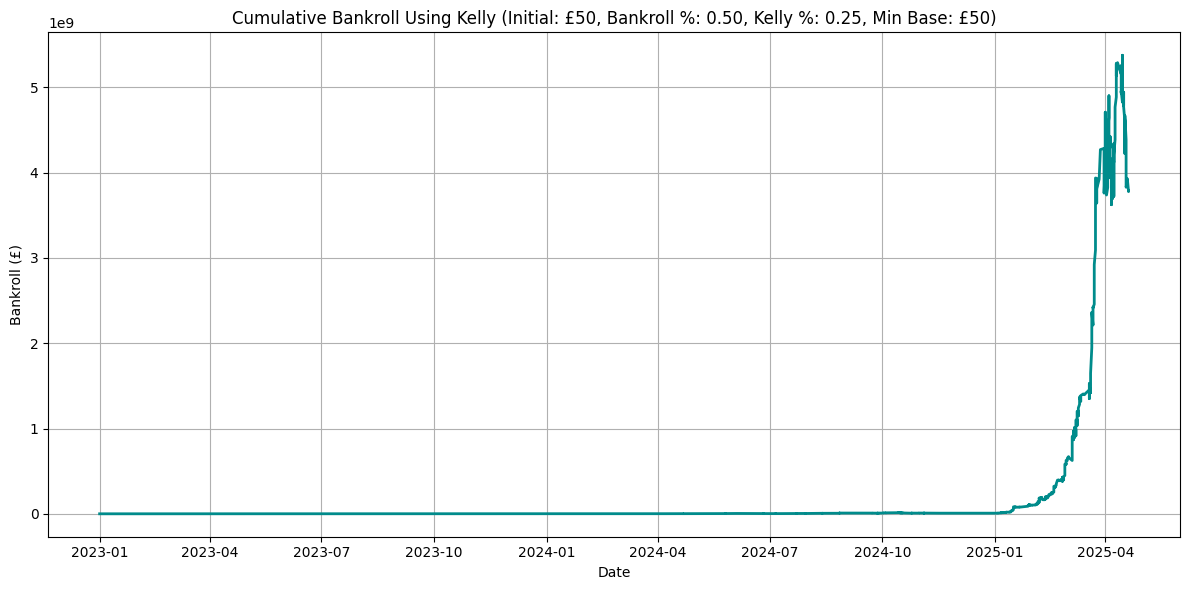

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £3784408062.05
Total Profit:     £3784408012.05
Total Staked:     £27183392788.70
Final ROI:        13.92%
Peak Bankroll:    £5375983690.45 on 2025-04-15
Min Bankroll:     £43.74 on 2023-01-04


In [32]:
plot_kelly_dynamic_proportional_bankroll(odds_win_df_23_25, bankroll_fraction=0.5, kelly_fraction=0.25)

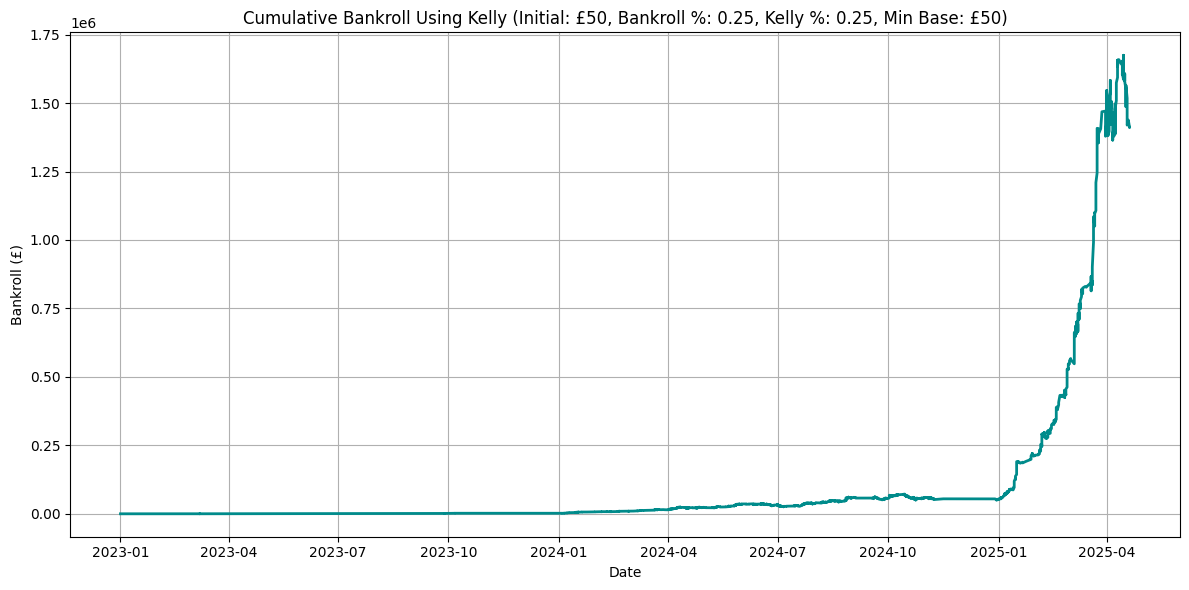

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £1411632.71
Total Profit:     £1411582.71
Total Staked:     £6916858.72
Final ROI:        20.41%
Peak Bankroll:    £1674634.71 on 2025-04-15
Min Bankroll:     £43.74 on 2023-01-04


In [33]:
plot_kelly_dynamic_proportional_bankroll(odds_win_df_23_25, bankroll_fraction=0.25, kelly_fraction=0.25)

In [34]:
def plot_kelly_dynamic_proportional_bankroll(
    odds_win_df,
    initial_bankroll=50,
    bankroll_fraction=1.0,
    kelly_fraction=1.0,
    min_bankroll=50,
    threshold=2000
):
    """
    Simulates Kelly staking using a cumulative bankroll, with dynamic reduction of stake sizing
    when bankroll crosses specified thresholds.

    Parameters:
        odds_win_df (pd.DataFrame): Must include 'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'
        initial_bankroll (float): Starting bankroll value
        bankroll_fraction (float): Starting proportion of the bankroll used to size each bet (0.5 = half bankroll)
        kelly_fraction (float): Fraction of the full Kelly stake to use (e.g. 0.25 for quarter-Kelly)
        min_bankroll (float): Minimum bankroll base to use for bet sizing (e.g. £50)
        threshold (float): The bankroll level at which to halve the bankroll_fraction
    """
    df = odds_win_df.copy()
    df.columns = df.columns.str.lower()

    required_cols = {'date', 'pred_win', 'model_odds', 'odds', 'won', 'model_prob'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")

    df['date'] = pd.to_datetime(df['date'])

    # Filter value bets where model predicts a win and sees value
    filtered = df[(df['pred_win'] == 1) & (df['model_odds'] < df['odds'])].copy()
    if filtered.empty:
        print("No qualifying value bets found.")
        return filtered

    filtered = filtered.sort_values('date').reset_index(drop=True)

    bankroll = initial_bankroll
    current_fraction = bankroll_fraction
    stakes = []
    profits = []
    bankrolls = []

    while_threshold = threshold

    for _, row in filtered.iterrows():
        # Halve the stake fraction when bankroll crosses the threshold
        while bankroll >= while_threshold:
            current_fraction /= 2
            while_threshold *= 2  # Next threshold is doubled

        b = row['odds'] - 1
        p = row['model_prob']
        q = 1 - p

        base = max(bankroll * current_fraction, min_bankroll)

        kelly_raw = (b * p - q) / b
        stake = max(kelly_raw, 0) * kelly_fraction * base

        profit = stake * (row['odds'] - 1) if row['won'] else -stake
        bankroll += profit

        stakes.append(stake)
        profits.append(profit)
        bankrolls.append(bankroll)

    filtered['stake'] = stakes
    filtered['profit'] = profits
    filtered['bankroll'] = bankrolls

    # Plot bankroll over time
    plt.figure(figsize=(12, 6))
    plt.plot(filtered['date'], filtered['bankroll'], linewidth=2, color='darkcyan')
    plt.title(
        f"Cumulative Bankroll Using Kelly (Initial: £{initial_bankroll}, "
        f"Starting %: {bankroll_fraction:.2f}, Kelly %: {kelly_fraction:.2f}, Min Base: £{min_bankroll})"
    )
    plt.xlabel("Date")
    plt.ylabel("Bankroll (£)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    final_bankroll = bankrolls[-1]
    total_profit = final_bankroll - initial_bankroll
    total_staked = sum(stakes)
    roi = (total_profit / total_staked) * 100 if total_staked > 0 else 0

    max_bankroll = max(bankrolls)
    min_bankroll_val = min(bankrolls)
    max_date = filtered.loc[filtered['bankroll'].idxmax(), 'date'].date()
    min_date = filtered.loc[filtered['bankroll'].idxmin(), 'date'].date()

    print(f"Proportional Kelly Summary ({len(filtered)} bets):")
    print(f"Initial Bankroll: £{initial_bankroll:.2f}")
    print(f"Final Bankroll:   £{final_bankroll:.2f}")
    print(f"Total Profit:     £{total_profit:.2f}")
    print(f"Total Staked:     £{total_staked:.2f}")
    print(f"Final ROI:        {roi:.2f}%")
    print(f"Peak Bankroll:    £{max_bankroll:.2f} on {max_date}")
    print(f"Min Bankroll:     £{min_bankroll_val:.2f} on {min_date}")


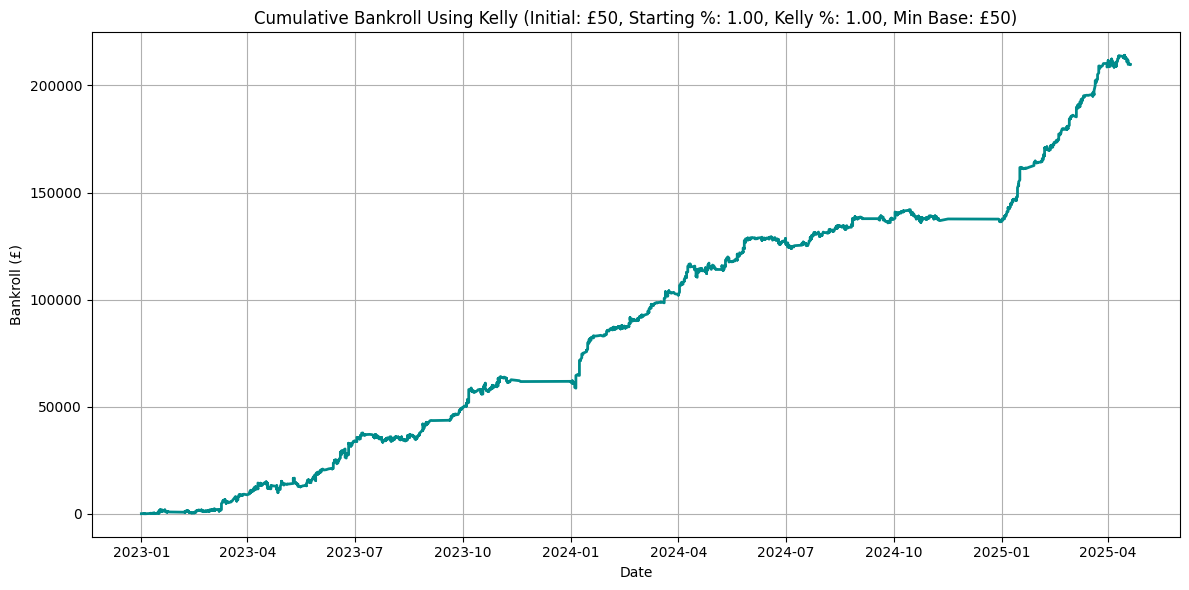

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £209672.42
Total Profit:     £209622.42
Total Staked:     £1042069.46
Final ROI:        20.12%
Peak Bankroll:    £214089.61 on 2025-04-15
Min Bankroll:     £8.85 on 2023-01-04


In [35]:
plot_kelly_dynamic_proportional_bankroll(
    odds_win_df_23_25,
    initial_bankroll=50,
    bankroll_fraction=1.0,
    kelly_fraction=1.0,
    min_bankroll=50,
    threshold=2000)

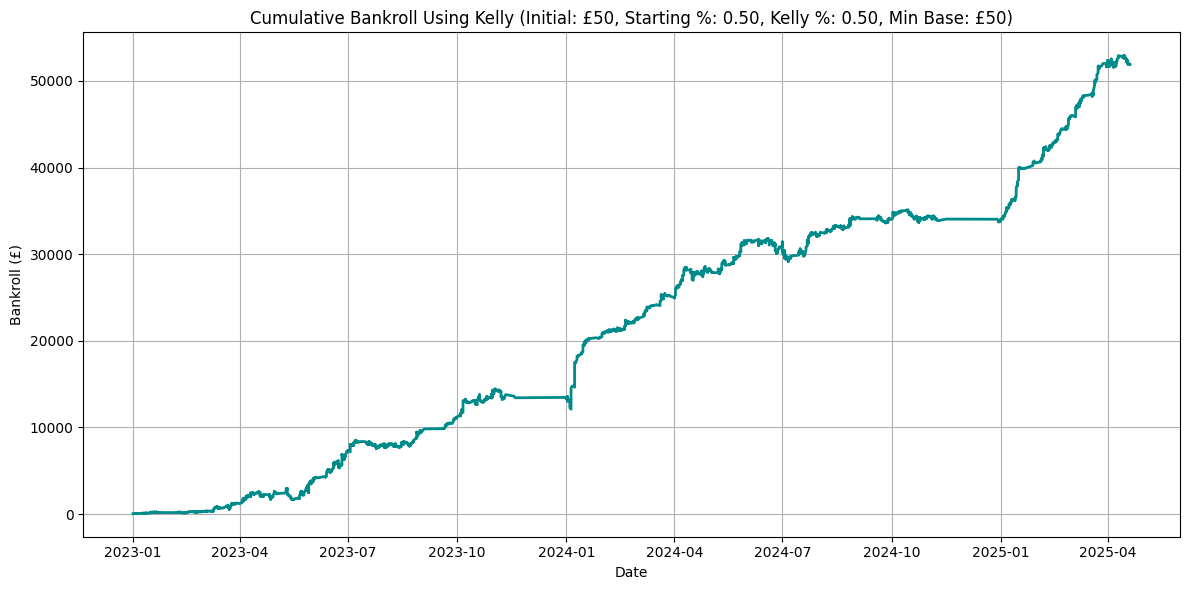

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £51873.76
Total Profit:     £51823.76
Total Staked:     £266173.47
Final ROI:        19.47%
Peak Bankroll:    £52966.60 on 2025-04-15
Min Bankroll:     £37.48 on 2023-01-04


In [36]:
plot_kelly_dynamic_proportional_bankroll(
    odds_win_df_23_25,
    initial_bankroll=50,
    bankroll_fraction=0.5,
    kelly_fraction=0.5,
    min_bankroll=50,
    threshold=2000)

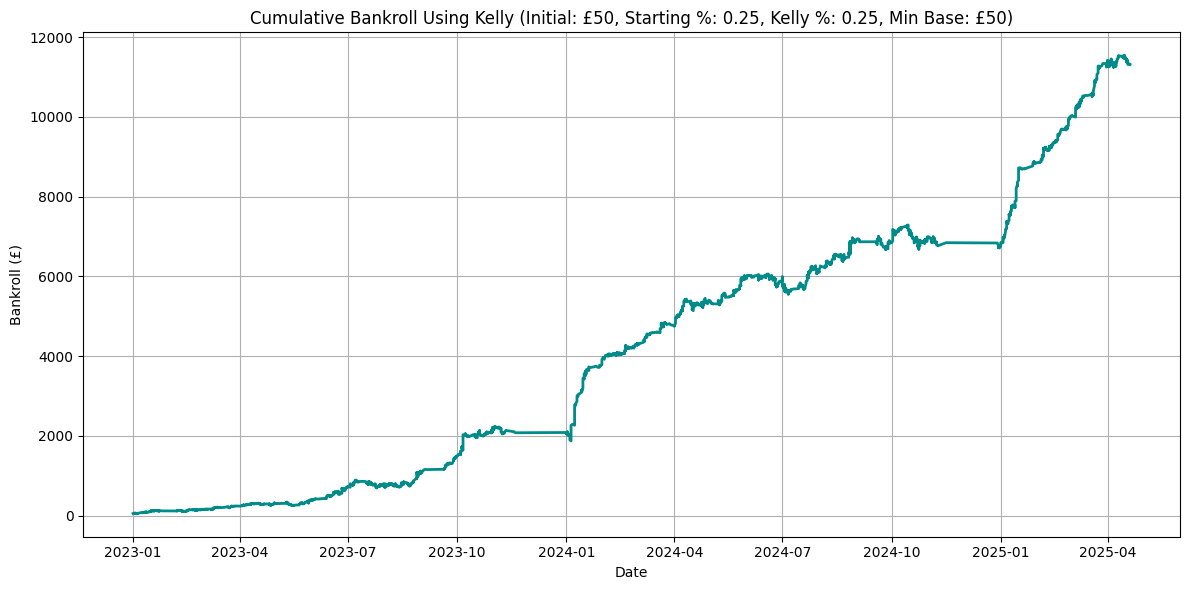

Proportional Kelly Summary (3388 bets):
Initial Bankroll: £50.00
Final Bankroll:   £11307.12
Total Profit:     £11257.12
Total Staked:     £56428.98
Final ROI:        19.95%
Peak Bankroll:    £11545.32 on 2025-04-15
Min Bankroll:     £43.74 on 2023-01-04


In [37]:
plot_kelly_dynamic_proportional_bankroll(
    odds_win_df_23_25,
    initial_bankroll=50,
    bankroll_fraction=0.25,
    kelly_fraction=0.25,
    min_bankroll=50,
    threshold=2000)